Shubhankar Sharma
IIIT Bhopal
Contact: 6266243366


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/into-the-future/test.csv
/kaggle/input/into-the-future/train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet as Prophet
from statsmodels.tsa.statespace.varmax import VARMAX

In [3]:
train_df = pd.read_csv('../input/into-the-future/train.csv')
test_df =pd.read_csv('../input/into-the-future/test.csv')
train_df_copy = train_df.copy()
test_df.copy = test_df.copy

In [4]:
train_df.head()

,id,time,feature_1,feature_2
0,0,2019-03-19 00:00:00,735.740043,54479.540513
1,1,2019-03-19 00:00:10,734.102947,47888.033714
2,2,2019-03-19 00:00:20,730.060336,47700.882325
3,3,2019-03-19 00:00:30,725.609742,47790.094648
4,4,2019-03-19 00:00:40,724.328480,47808.402381


In [5]:
train_df.tail()

,id,time,feature_1,feature_2
559,559,2019-03-19 01:33:10,423.726707,54115.388787
560,560,2019-03-19 01:33:20,424.278568,54127.830664
561,561,2019-03-19 01:33:30,420.127639,54092.561194
562,562,2019-03-19 01:33:40,421.291993,53994.714950
563,563,2019-03-19 01:33:50,423.257581,53863.615475


In [6]:
test_df.head()

,id,time,feature_1
0,564,2019-03-19 01:34:00,423.064004
1,565,2019-03-19 01:34:10,423.342749
2,566,2019-03-19 01:34:20,423.181186
3,567,2019-03-19 01:34:30,421.275243
4,568,2019-03-19 01:34:40,422.208444


In [7]:
train_df.describe()

,id,feature_1,feature_2
count,564.00000,564.000000,564.000000
mean,281.50000,523.754885,52487.426941
std,162.95705,70.507377,1582.206650
min,0.00000,420.127639,47700.882325
25%,140.75000,474.970260,51842.916087
50%,281.50000,501.204656,53170.608346
75%,422.25000,569.862105,53515.111143
max,563.00000,735.740043,54479.540513


In [8]:
test_df.describe()

,id,feature_1
count,375.000000,375.000000
mean,751.000000,409.334539
std,108.397417,28.841608
min,564.000000,364.045118
25%,657.500000,383.701342
50%,751.000000,401.488841
75%,844.500000,432.481531
max,938.000000,466.892616


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         564 non-null    int64  
 1   time       564 non-null    object 
 2   feature_1  564 non-null    float64
 3   feature_2  564 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 17.8+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         375 non-null    int64  
 1   time       375 non-null    object 
 2   feature_1  375 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.9+ KB


Lets check how feature_1 and feature_2 vary with time:

In [11]:
train_df['time'] = pd.to_datetime(train_df.time)
test_df['time'] = pd.to_datetime(test_df.time)

In [12]:
train_df.set_index('time', inplace=True)

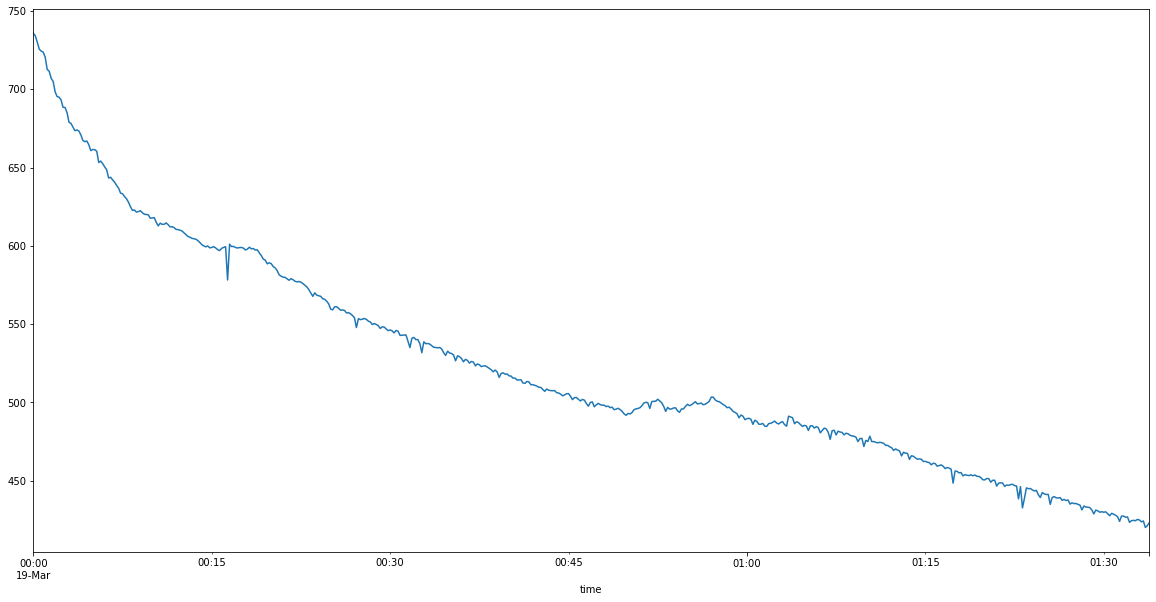

In [13]:
train_df['feature_1'].plot(figsize=(20,10))

Obervations:
1.) Sudden dip at around 00:15; probably due to just some random event. // can be removed, but we can't say enough without any other data
2.) Break in continously decreasing nature (overall, except for some random events) at 00:48, which breaks the trend.
3.) Continously decreasing nature (overall, except for some random events) at 00:58 begins again.
4.) Dip(s) similar to '00:15' at around 01:18, 01:23.

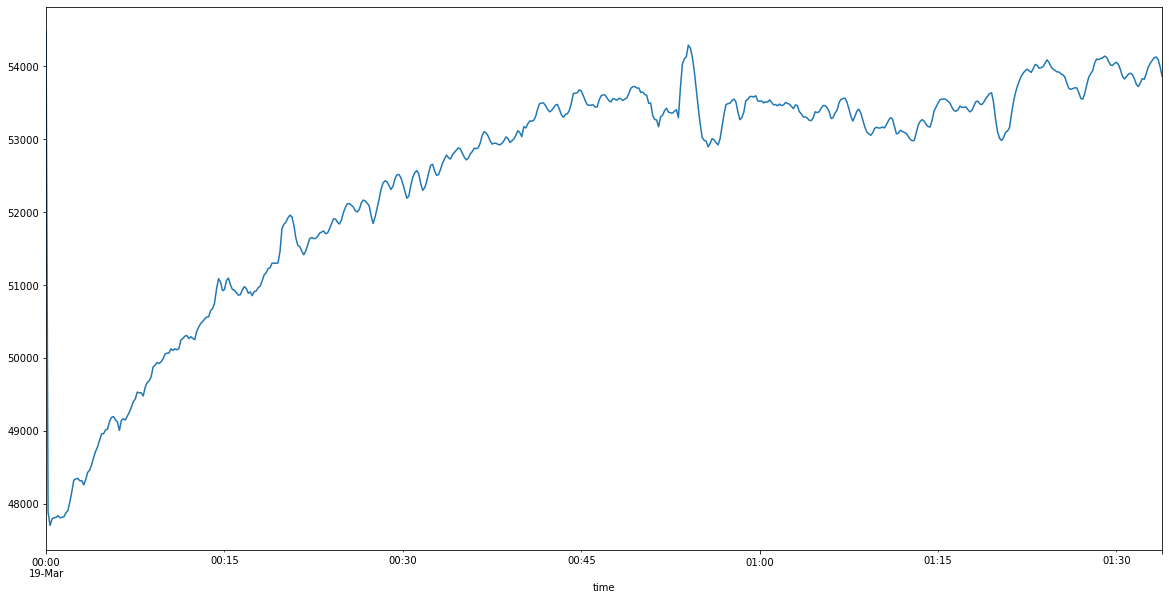

In [14]:
train_df['feature_2'].plot(figsize=(20,10))

Compared to feature_1, it is quite noisy with many more sudden dips and jumps all over.
A slight touch of seasonality can be noticed in some parts.



feature_1 and feature_2 are negatively corelated, it can be observed that the dips in 
feature_1 are accompanied with jumps in feature_2 and vice-versa.

In [15]:
print(train_df.columns)
print(test_df.columns)

Index(['id', 'feature_1', 'feature_2'], dtype='object')
Index(['id', 'time', 'feature_1'], dtype='object')


In [16]:
print(train_df.head())
print(test_df.head())

                     id   feature_1     feature_2
time                                             
2019-03-19 00:00:00   0  735.740043  54479.540513
2019-03-19 00:00:10   1  734.102947  47888.033714
2019-03-19 00:00:20   2  730.060336  47700.882325
2019-03-19 00:00:30   3  725.609742  47790.094648
2019-03-19 00:00:40   4  724.328480  47808.402381
    id                time   feature_1
0  564 2019-03-19 01:34:00  423.064004
1  565 2019-03-19 01:34:10  423.342749
2  566 2019-03-19 01:34:20  423.181186
3  567 2019-03-19 01:34:30  421.275243
4  568 2019-03-19 01:34:40  422.208444


In [17]:
test_df.set_index('time', inplace=True)

In [18]:
print(train_df.head())
print(test_df.head())

                     id   feature_1     feature_2
time                                             
2019-03-19 00:00:00   0  735.740043  54479.540513
2019-03-19 00:00:10   1  734.102947  47888.033714
2019-03-19 00:00:20   2  730.060336  47700.882325
2019-03-19 00:00:30   3  725.609742  47790.094648
2019-03-19 00:00:40   4  724.328480  47808.402381
                      id   feature_1
time                                
2019-03-19 01:34:00  564  423.064004
2019-03-19 01:34:10  565  423.342749
2019-03-19 01:34:20  566  423.181186
2019-03-19 01:34:30  567  421.275243
2019-03-19 01:34:40  568  422.208444


Observation: We have uniform time steps, so they become directly correlated to our indices, and the indices and time in the test data are a continuation of that in train data, So we'll drop the 'timetest_df.set_index('time', inplace=True)' column.**

In [19]:
test_df.set_index('id', inplace=True)
train_df.set_index('id', inplace=True)

In [20]:
print(train_df.head())
print(test_df.head())

     feature_1     feature_2
id                          
0   735.740043  54479.540513
1   734.102947  47888.033714
2   730.060336  47700.882325
3   725.609742  47790.094648
4   724.328480  47808.402381
      feature_1
id             
564  423.064004
565  423.342749
566  423.181186
567  421.275243
568  422.208444


In [21]:
#We can now split the training dataset in train and valid
#Due to such a small dataset we'll keep the validition set at 10% of the training set
train = train_df[:int(0.9*len(train_df))]
valid = train_df[int(0.9*len(train_df)):]

In [22]:
print(train.shape)
print(valid.shape)

(507, 2)
(57, 2)


In [23]:
train.head()

,feature_1,feature_2
id,,
0,735.740043,54479.540513
1,734.102947,47888.033714
2,730.060336,47700.882325
3,725.609742,47790.094648
4,724.328480,47808.402381


We'll try Simple VARMAX RNN, LSTM and ConvNets. 

**1.) VARMAX (Vector Autoregressive Moving Average model with eXogenous variables).**

In [24]:
from statsmodels.tsa.statespace.varmax import VARMAX

model1 = VARMAX(train)
model1_fit = model1.fit()

In [25]:
preds = model1_fit.forecast(steps=len(valid))
preds.head(10)

,feature_1,feature_2
507,444.630124,54141.827602
508,445.419658,54199.267879
509,446.205788,54233.340034
510,446.987705,54251.399970
511,447.764865,54258.500809
512,448.536909,54258.113686
513,449.303607,54252.622927
514,450.064813,54243.666230
515,450.820441,54232.368370
516,451.570445,54219.501751


In [26]:
#importing MAE and MSE for metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [27]:
import math
rmse=math.sqrt(MSE(preds,valid))
print('Mean absolute error is: '+ str(MAE(preds,valid)))
print('Root Mean Squared error is: ' + str(rmse))

Mean absolute error is: 145.34370904420948
Root Mean Squared error is: 220.48511984812345


In [28]:
full_model = VARMAX(train_df)
full_model_fit = full_model.fit()

In [29]:
preds = full_model_fit.forecast(steps=len(test_df))

In [30]:
predictions = pd.DataFrame(preds)
predictions.to_csv('results.csv')

In [31]:
#Work_In_Progress
#Check_Pt_1: RMSE = 220.48511984812345 | MAE = 145.34370904420948
#With VARMAX
#Would be using other models soon